# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. Вывод являяется обязательным!

In [3]:
!gsutil cp gs://boolq/train.jsonl .
!gsutil cp gs://boolq/dev.jsonl .

Copying gs://boolq/train.jsonl...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      
Copying gs://boolq/dev.jsonl...
/ [1 files][  2.1 MiB/  2.1 MiB]                                                
Operation completed over 1 objects/2.1 MiB.                                      


### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

# Соображения по методологии

# Проведение одного эксперимента
1. Подбирайте гиперпараметры! Это довольно важно. Гиперпараметры --- это размеры слоёв, например. Хотя бы в одном эксперименте это стоит сделать честно, в остальных экспериментах в принципе можно предполагать, что в предыдущем эксперименте оптимальные размеры модели уже найдены.
2. Часто вам придётся скачивать предобученные веса (вроде BERT или RoBERTa) и дообучать дополнительные веса. В таком случае стоит попробовать несколько разных подходов:
* обучать только новые (головные) слои 
* обучать совместно всю модель
* сначала обучить головные слои, потом дофайнтьюнить веса всей модели
3. Фиксируйте лучшие результаты на валидационной выборке, по валидационной же выборке останавливайте обучение
4. Графики, графики, графики
5. Делайте промежуточные выводы

# Общие соображения
1. Один эксперимент --- одно изменение! Вы не представляете, насколько это важно. Пример: для эксперимента с моделью 1 Петя для получения эмбеддингов скачал предобученные веса BERT, а для эксперимента с моделью 2 -- предобученные веса RoBERTa. Вторая модель оказалась лучше, и Петя подумал, что архитектура второй модели лучше. Но, оказывается, с весами RoBERTa модель 1 работала бы не менее хорошо. 
2. Всегда сравнивайте результаты эксперимента с результатами всех остальных экспериментов и делайте промежуточные выводы. ***Это самый важный пункт!***
3. Не забывайте протестировать модель на адекватность. Для этого нужно задавать ей реальные вопросы и смотреть на ответы. Вопросы не должны быть элементами обучающей выборки!


In [4]:
!wget -q https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip -q v0.9.2.zip

In [5]:
!ls fastText-0.9.2

alignment		   fasttext.pc.in	    scripts
classification-example.sh  get-wikimedia.sh	    setup.cfg
classification-results.sh  LICENSE		    setup.py
CMakeLists.txt		   Makefile		    src
CODE_OF_CONDUCT.md	   MANIFEST.in		    tests
CONTRIBUTING.md		   python		    webassembly
crawl			   quantization-example.sh  website
docs			   README.md		    wikifil.pl
download_model.py	   reduce_model.py	    word-vector-example.sh
eval.py			   runtests.py


In [6]:
%%bash
cd fastText-0.9.2
pip install -q .

In [7]:
!pip install -q transformers

     |████████████████████████████████| 2.5MB 4.1MB/s 
     |████████████████████████████████| 3.3MB 48.5MB/s 
     |████████████████████████████████| 901kB 50.6MB/s 


In [8]:
!pip install -U sentence-transformers

     |████████████████████████████████| 92kB 3.3MB/s 
     |████████████████████████████████| 1.2MB 5.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-cp37-none-any.whl size=126711 sha256=9108253faa8c5ab1e874f79f1a5a703e0e626b7898452d9e82c1176becdf003d
  Stored in directory: /root/.cache/pip/wheels/38/d2/98/d191289a877a34c68aa67e05179521e060f96394a3e9336be6
Successfully built sentence-transformers


In [9]:
import json
from typing import List
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import WordPunctTokenizer
import fasttext
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer, BertForQuestionAnswering, RobertaForQuestionAnswering, BertForSequenceClassification
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [10]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [11]:
import functions_module
from functions_module import transform_logits, transform_target, plot, train, evaluate, epoch_time, train_eval_loop
import imp
imp.reload(functions_module)

<module 'functions_module' from '/content/drive/MyDrive/functions_module.py'>

## Часть 1. Эксплоративный анализ (1 балл)
1. Посчитайте долю yes и no классов в корпусе
2. Оцените среднюю длину вопроса
3. Оцените среднюю длину параграфа
4. Предположите, по каким эвристикам были собраны вопросы (или найдите ответ в статье). Продемонстрируйте, как эти эвристики повлияли на структуру корпуса. 

In [12]:
!head train.jsonl

{"question": "do iran and afghanistan speak the same language", "title": "Persian language", "answer": true, "passage": "Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet."}
{"question": "do good samaritan laws protect those who help at an accident", "title": "Good Samaritan law", "answer": true, "passage": "Good Samaritan laws offer legal protection to people who give reasonable assistance to those who are, or who they believe to be, injured, ill, in peril, o

In [13]:
def read_data(file):
    new_data = {'question': [], 'title': [], 'answer': [], 'passage': []}
    with open(file) as f:
        data = [json.loads(line) for line in f]
        for rec in data:
            new_data['question'].append(rec['question'])
            new_data['title'].append(rec['title'])
            new_data['answer'].append(rec['answer'])
            new_data['passage'].append(rec['passage'])
    return new_data


tr_data = read_data('train.jsonl')
dev_data = read_data('dev.jsonl')

In [14]:
print(f"'question': {tr_data['question'][0]}\n'title': {tr_data['title'][0]}\n'answer': {tr_data['answer'][0]}\n'passage': {tr_data['passage'][0]}")

'question': do iran and afghanistan speak the same language
'title': Persian language
'answer': True
'passage': Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.


In [15]:
def get_answer_count_percentage(answers: List[bool]):
    count_percentage = {'count': [], 'perc': []}

    count_percentage['count'].append(Counter(answers)[True])
    count_percentage['count'].append(Counter(answers)[False])
    count_percentage['perc'].append(Counter(answers)[True]/len(answers))
    count_percentage['perc'].append(Counter(answers)[False]/len(answers))
    
    return count_percentage

In [16]:
tr_perc_true = get_answer_count_percentage(tr_data["answer"])['perc'][0]
tr_perc_false = get_answer_count_percentage(tr_data["answer"])['perc'][1]
dev_perc_true = get_answer_count_percentage(dev_data["answer"])['perc'][0]
dev_perc_false = get_answer_count_percentage(dev_data["answer"])['perc'][1]

print("Train True: %.3f | Train False: %.3f" % (tr_perc_true, tr_perc_false))
print("Dev True:   %.3f | Dev False:   %.3f" % (dev_perc_true, dev_perc_false))

Train True: 0.623 | Train False: 0.377
Dev True:   0.622 | Dev False:   0.378


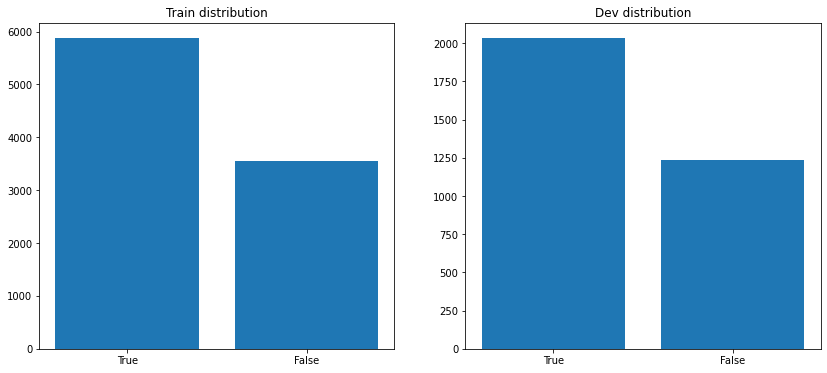

In [17]:
tr_count = get_answer_count_percentage(tr_data["answer"])['count']
dev_count = get_answer_count_percentage(dev_data["answer"])['count']

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].bar(x=['True', 'False'], height=tr_count)
axs[0].set_title('Train distribution')
axs[1].bar(x=['True', 'False'], height=dev_count)
axs[1].set_title('Dev distribution')

plt.show()

In [18]:
tokenizer = WordPunctTokenizer()

def average_length(sents: List[str]):
    tokens_quests = [tokenizer.tokenize(sent) for sent in sents]
    av_len = sum([len(sent) for sent in tokens_quests]) / len(tokens_quests)
    return round(av_len)


av_len_tr_quest = average_length(tr_data['question'])
av_len_dev_quest = average_length(dev_data['question'])

av_len_tr_pas = average_length(tr_data['passage'])
av_len_dev_pas = average_length(dev_data['passage'])

print("Train average question lengtn: %i   | Dev average question lengtn: %i" % (av_len_tr_quest, av_len_dev_quest))
print("Train average passage lengtn:  %i | Dev average passage lengtn:  %i" % (av_len_tr_pas, av_len_dev_pas))

Train average question lengtn: 9   | Dev average question lengtn: 9
Train average passage lengtn:  111 | Dev average passage lengtn:  110


Специфика датасета состоит в том, что предполагаются бинарные ответы на нефактологические вопросы, т.е. модели необходимо сделать сложные умозаключения. 

Пример экземпляра:

'question': do iran and afghanistan speak the same language
'title': Persian language
'answer': True
'passage': Persian (/ˈpɜːrʒən, -ʃən/), also known by its endonym Farsi (فارسی fārsi (fɒːɾˈsiː) ( listen)), is one of the Western Iranian languages within the Indo-Iranian branch of the Indo-European language family. It is primarily spoken in Iran, Afghanistan (officially known as Dari since 1958), and Tajikistan (officially known as Tajiki since the Soviet era), and some other regions which historically were Persianate societies and considered part of Greater Iran. It is written in the Persian alphabet, a modified variant of the Arabic script, which itself evolved from the Aramaic alphabet.

Датасет хорош для проверки обобщающей способности моделей. Так, даже человек способен лишь на 90% правильных ответов.

## Часть 2. Baseline (1 балл)
1. Оцените accuracy точность совсем простого базового решения: присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части
2. Оцените accuracy чуть более сложного базового решения: fasttext на текстах, состоящих из склееных вопросов и абзацев (' '.join([question, passage]))

Почему fasttext плохо справляется с этой задачей?

1. Исходя из полученного соотношения классов, accuracy будет равно 0.62.

2. Получим результат с помощью fasttext.

In [19]:
def get_fasttext_data(data=None, file_name=None):
    answer = data['answer']
    question = data['question']
    passage = data['passage']

    fasttext_data = ['__label__' + str(a) + ' ' + q + ' ' + p for a, q, p in zip(answer, question, passage)]

    f = open(file_name, "w")

    for line in fasttext_data:
        f.write(line + '\n')


get_fasttext_data(tr_data, 'train_ft_data')
get_fasttext_data(dev_data, 'dev_ft_data')

In [65]:
ft_model = fasttext.train_supervised(input='train_ft_data', lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=300, loss='hs')

In [ ]:
ft_model.test('dev_ft_data')

(3270, 0.6877675840978593, 0.6877675840978593)

In [ ]:
dev_data['question'][2], dev_data['answer'][2]

('is pain experienced in a missing body part or paralyzed area', True)

In [ ]:
ft_model.predict(dev_data['question'][2] + '?')

(('__label__True',), array([1.00000489]))

Результат оказался только на 0.07 лучше.
FASTTEXT довльно простая модель, основанная на BOW c одним скрытым слоем, поэтому вряд ли стоит ожидать хорошего качества для QA, даже для предобученной модели. Хотя с предобученными векторами на Wikipedia (где и формировался BoolQ) разница должна быть ощутимей.

Теперь попробуем предобученный fasttext

In [52]:
# import requests, zipfile, io, os
# from gensim.models.fasttext import FastText


# #download model
# ft_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.bin.zip'
# zpath = 'wiki-news-300d-1M-subword.bin.zip'
# mpath = 'wiki-news-300d-1M-subword.bin'

# if os.path.isfile(mpath):
#     #attempt load
#     mod = FastText.load_fasttext_format(mpath,encoding='utf-8')
# elif not os.path.isfile(zpath):
#     r = requests.get(ft_url)
#     z = zipfile.ZipFile(io.BytesIO(r.content))
#     z.extractall()
# else:
#     z = zipfile.ZipFile(zpath)
#     z.extractall()
#     mod = FastText.load_fasttext_format(mpath,encoding='utf-8')

In [57]:
# mod = FastText.load_fasttext_format('wiki-news-300d-1M-subword.bin')
# mod.score('dev_ft_data')

In [34]:
# !unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wiki-news-300d-1M.vec   


In [38]:
# %cd /content/drive/MyDrive/wiki-news-300d-1M.vec

[Errno 20] Not a directory: '/content/drive/MyDrive/wiki-news-300d-1M.vec'
/content/drive/MyDrive


In [58]:
# import io

# def load_vectors(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data

# pretrained = load_vectors('/content/drive/MyDrive/wiki-news-300d-1M.vec/')

## Часть 3. Используем эмбеддинги предложений (2 балла)
1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

[bonus] Используйте другие модели эмбеддингов, доступные, например, в библиотеке 🤗 Transformers. Какая модель эмбеддингов даст лучшие результаты?

[bonus] Предложите метод аугментации данных и продемонстрируйте его эффективность. 

In [62]:
st_model = SentenceTransformer('bert-base-nli-cls-token')

In [63]:
# bert_base_cased = BertModel.from_pretrained('bert-base-cased')
# bbc_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def get_embeddings(data, model):
    question = data['question']
    passage = data['passage']

    encoded_question = model.encode(question)
    encoded_passage = model.encode(passage)
    sentence_embeddings = np.concatenate((encoded_question, encoded_passage), axis=1)

    return sentence_embeddings

tr_emb = get_embeddings(tr_data, st_model)
dev_emb = get_embeddings(dev_data, st_model)

In [64]:
le = LabelEncoder()
tr_labels = le.fit_transform(tr_data['answer'])
dev_labels = le.fit_transform(dev_data['answer'])

clf = LogisticRegression(max_iter=10000).fit(tr_emb, tr_labels)
clf.predict(dev_emb)
print(f'Accuracy: {clf.score(dev_emb, dev_labels)}')

Accuracy: 0.6639143730886851


## Часть 4. Обучаем BERT на конкатенации вопроса и предложения (2 балла)

В этой части предлагается реализовать фреймворк, описанный в [видео по ссылке](https://www.youtube.com/watch?v=l8ZYCvgGu0o), адаптировав его под бинарный Question Answering. 

1. Опишите модель, которую вы будете реализовывать. Загрузите предобученный BERT, добавьте полносвязные "головные" слои. Дообучите модель: попробуйте разные способы обучения.

[bonus] Используйте модель [RoBERTa](https://arxiv.org/abs/1907.11692) вместо модели BERT. Посмотрите, что получилось.

In [ ]:
bfqa_pretrained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
bfqa_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
class QADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=400): 
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.labels = list(set(self.data['answer']))
        self.label2num = {l: num for num, l in enumerate(self.labels)}

    def __getitem__(self, index):
        question = self.data['question'][index]
        answer = self.data['answer'][index]
        passage = self.data['passage'][index]

        tokenizer_output = self.tokenizer.encode_plus(
                            question,
                            passage,
                            add_special_tokens=True,
                            max_length=self.max_length,
                            pad_to_max_length=True,
                            truncation_strategy='longest_first',
                            return_token_type_ids=True
        )
  
        target = self.label2num[answer]

        return {
            'input_ids': torch.tensor(tokenizer_output['input_ids'], dtype=torch.long).squeeze(0),
            'token_type_ids': torch.tensor(tokenizer_output['token_type_ids'], dtype=torch.long).squeeze(0),
            'attention_mask': torch.tensor(tokenizer_output['attention_mask'], dtype=torch.long).squeeze(0),
            'labels': torch.tensor(target, dtype=torch.long).squeeze(0)
        }

    def __len__(self):
        return len(self.data['question'])


tr_dataset = QADataset(tr_data, bfqa_tokenizer)
dev_dataset = QADataset(dev_data, bfqa_tokenizer)

In [ ]:
print(tr_dataset.__len__())

9427


In [ ]:
b = tr_dataset.label2num
print(f'Кодировка лейблов:\n{b}')

Кодировка лейблов:
{False: 0, True: 1}


In [ ]:
tr_dataloader = DataLoader(tr_dataset, batch_size=16, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=16, shuffle=True)

In [ ]:
class QAModel(nn.Module):

    def __init__(self, pretrained_model, dropout=0.1):
        super().__init__()

        self.bert = pretrained_model
        # self.dropout = nn.Dropout(p=dropout)
        # self.relu = nn.ReLU()

        # self.fc_1 = nn.Linear(2, 128)
        # self.fc_2 = nn.Linear(128, 2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inputs, attention_mask, token_type_ids, labels):
        
        outputs = self.bert(input_ids=inputs, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        # x = self.relu(self.fc_1(outputs.logits))
        # x = self.fc_2(self.dropout(x))
        probs = self.sigmoid(outputs.logits)
        #print(probs)
        loss = outputs.loss
       
        return probs, loss

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
qa_bert_model = QAModel(bfqa_pretrained_model)
qa_bert_model = qa_bert_model.to(device)
optimizer = optim.Adam(qa_bert_model.parameters(), lr=2e-5)

In [ ]:
print(device)

cuda


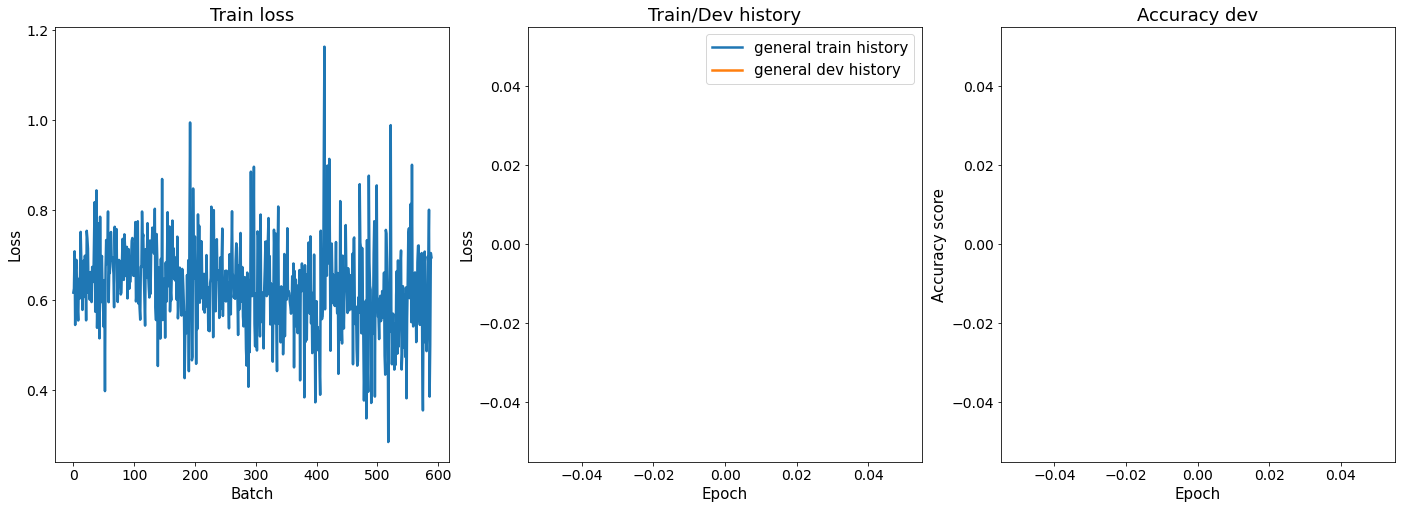

NameError: ignored

In [ ]:
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})

N_EPOCHS = 15
CLIP = 5

sc = train_eval_loop(qa_bert_model, train, tr_dataloader, evaluate, dev_dataloader, optimizer, N_EPOCHS, CLIP, plot)

Результат обучения BertForSentenceClassification. Показал наилучшее качество среди представленных моделей ~ 0.75

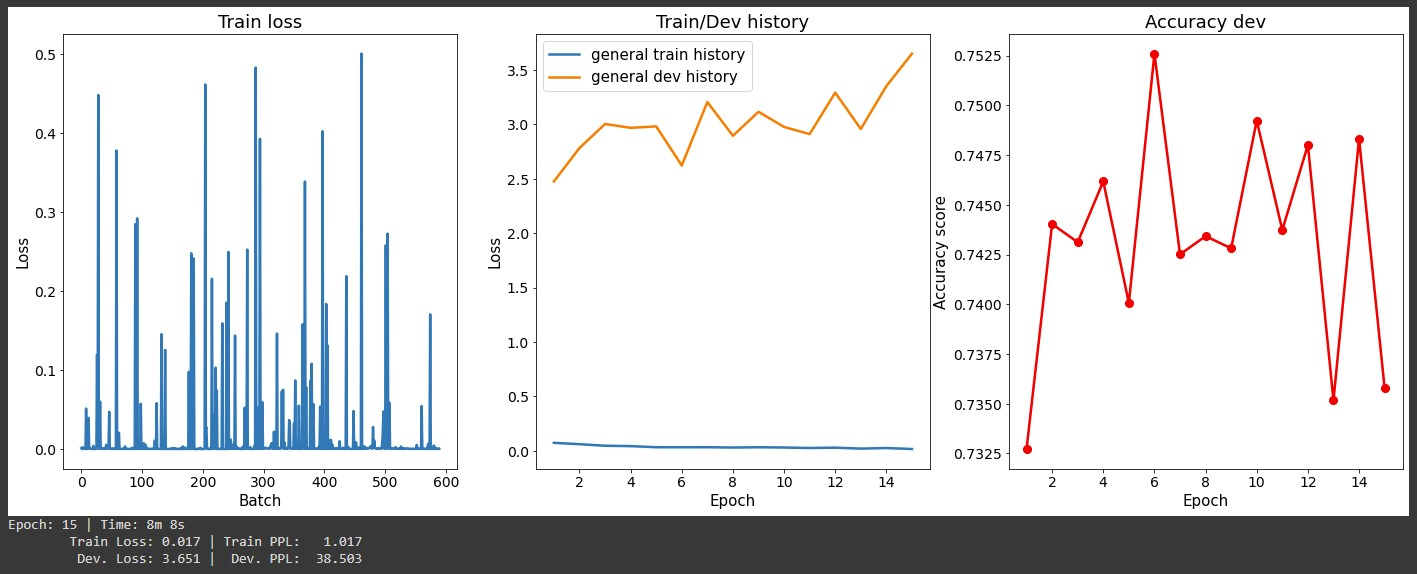

## Часть 5. BiDAF-подобная архитектура (2 балла)

Архитектура BiDAF является специфической архитектурой для QA. Здесь вам предлагается её реализовать.

Основана на статье: Bidirectional Attention Flow for Machine Comprehension

Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi

https://arxiv.org/abs/1611.01603

Архитектура BiDAF предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик  получает на вход два представления слова: эмбеддинг слова и полученное из CNN посимвольное представление слова. Кодировщики для вопроса и для параграфа одинаковы. 
2. Слой внимания (детальное описание приведено в статье, см. пункт Attention Flow Layer)
3. Промежуточный слой, который получает на вход контекстуализированные эмбеддинги слов из параграфа, состоящие из трех частей (выход кодировщика параграфа,   Query2Context (один вектор) и Context2Query (матрица) выравнивания

4. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре BiDAF, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT или RoBERTa эмбеддинги. Улучшит ли это качество результатов?

Сравнение DrQA и BiDAF:
    
![](https://www.researchgate.net/profile/Felix_Wu6/publication/321069852/figure/fig1/AS:560800147881984@1510716582560/Schematic-layouts-of-the-BiDAF-left-and-DrQA-right-architectures-We-propose-to.png)

### 5.1 Char and word embeddings 

In [ ]:
q = bfqa_tokenizer.tokenize(tr_dataset.data['question'][0])
q[3:5]

['afghanistan', 'speak']

In [ ]:
words_by_chars = [list(x) for x in q]
chars_vocab = list(set([x for y in words_by_chars for x in y]))
labs = {l: num+1 for num, l in enumerate(chars_vocab)}
encoded = [[labs[x]  for x in y] for y in words_by_chars]
print(chars_vocab, '\n', labs, '\n', words_by_chars, '\n', encoded)

['f', 'h', 'r', 's', 'l', 'o', 'k', 'g', 't', 'n', 'u', 'a', 'p', 'e', 'm', 'i', 'd'] 
 {'f': 1, 'h': 2, 'r': 3, 's': 4, 'l': 5, 'o': 6, 'k': 7, 'g': 8, 't': 9, 'n': 10, 'u': 11, 'a': 12, 'p': 13, 'e': 14, 'm': 15, 'i': 16, 'd': 17} 
 [['d', 'o'], ['i', 'r', 'a', 'n'], ['a', 'n', 'd'], ['a', 'f', 'g', 'h', 'a', 'n', 'i', 's', 't', 'a', 'n'], ['s', 'p', 'e', 'a', 'k'], ['t', 'h', 'e'], ['s', 'a', 'm', 'e'], ['l', 'a', 'n', 'g', 'u', 'a', 'g', 'e']] 
 [[17, 6], [16, 3, 12, 10], [12, 10, 17], [12, 1, 8, 2, 12, 10, 16, 4, 9, 12, 10], [4, 13, 14, 12, 7], [9, 2, 14], [4, 12, 15, 14], [5, 12, 10, 8, 11, 12, 8, 14]]


In [ ]:
enc = bfqa_tokenizer.encode_plus(words_by_chars[3],
                            add_special_tokens=False,
                            max_length=30,
                            pad_to_max_length=True,
                            truncation_strategy='longest_first',
                            return_token_type_ids=None
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
enc

{'input_ids': [1037, 1042, 1043, 1044, 1037, 1050, 1045, 1055, 1056, 1037, 1050, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
from torchtext.legacy.data import BucketIterator
device = "cuda" if torch.cuda.is_available() else "cpu"
train_iter = BucketIterator.splits(
    train, 
    batch_size = 2,
    sort_within_batch = True,
    device = device)

TypeError: ignored

In [ ]:
encoded[3:5]

[[12, 1, 8, 2, 12, 10, 16, 4, 9, 12, 10], [4, 13, 14, 12, 7]]

In [ ]:
char_emb = nn.Embedding(300, 3, padding_idx=0)
char2vec = char_emb(torch.LongTensor(encoded[3]))

In [ ]:
char2vec

tensor([[-0.5083, -0.4992,  1.7482],
        [ 0.9159,  0.0111, -1.7113],
        [-1.5412, -0.7197, -0.6968],
        [ 0.4766,  1.5479,  0.6185],
        [-0.5083, -0.4992,  1.7482],
        [-1.2822, -1.3545,  1.1573],
        [-0.0214, -0.0118,  0.3295],
        [ 1.8537,  1.0896, -0.7075],
        [-0.5672,  0.0033,  0.0253],
        [-0.5083, -0.4992,  1.7482],
        [-1.2822, -1.3545,  1.1573]], grad_fn=<EmbeddingBackward>)

In [ ]:
conv = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3)

In [ ]:
conv(char2vec.unsqueeze(2))

RuntimeError: ignored

In [ ]:
class CharEmbByCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
    ):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)

        self.conv_0 = nn.Conv1d(emb_dim, out_channels, kernel_sizes[0], padding=1, stride=2)
        
        self.conv_1 = nn.Conv1d(emb_dim, out_channels, kernel_sizes[1], padding=0, stride=1)
                                    
        self.conv_2 = nn.Conv1d(emb_dim, out_channels, kernel_sizes[2], padding=0, stride=1)
        
        
    def forward(self, text):
        
        embedded = self.embedding(torch.tensor(text, dtype=torch.long)).unsqueeze(0)
        print(embedded.shape)
        embedded = embedded.permute(0, 2, 1)  
        
        conved_0 = F.relu(self.conv_0(embedded))  
        print(conved_0.shape)
        conved_1 = F.relu(self.conv_1(embedded))  
        conved_2 = F.relu(self.conv_2(embedded)) 
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = torch.cat((pooled_0, pooled_1, pooled_2), dim=1)
            
        return cat

In [ ]:
kernel_sizes = [3, 4, 5]

out_channels=1
dim = 300

model = None
torch.cuda.empty_cache()
model = CharEmbByCNN(vocab_size=len(chars_vocab), emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes)

In [ ]:
model(encoded[3])

torch.Size([1, 11, 300])
torch.Size([1, 1, 6])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[0.8046, 1.1995, 0.1108]], grad_fn=<CatBackward>)

In [ ]:
# class BiDAF_Dataset(Dataset):
#     def __init__(self, data, tokenizer, max_length=400): #
#         self.data = data
#         self.tokenizer = tokenizer
#         self.max_length = max_length
#         self.labels = [False, True]
#         self.label2num = {l: num for num, l in enumerate(self.labels)}

#     def __getitem__(self, index):
#         question = self.data['question'][index]
#         answer = self.data['answer'][index]
#         passage = self.data['passage'][index]

#         tokenizer_output = self.tokenizer.encode_plus(
#                             question,
#                             passage,
#                             add_special_tokens=True,
#                             max_length=self.max_length,
#                             pad_to_max_length=True,
#                             truncation_strategy='longest_first',
#                             return_token_type_ids=True
#         )
  
#         target = self.label2num[answer]


#         return {
#             'input_ids': torch.tensor(tokenizer_output['input_ids'], dtype=torch.long).squeeze(0),
#             'token_type_ids': torch.tensor(tokenizer_output['token_type_ids'], dtype=torch.long).squeeze(0),
#             'attention_mask': torch.tensor(tokenizer_output['attention_mask'], dtype=torch.long).squeeze(0),
#             'labels': torch.tensor(target, dtype=torch.long).squeeze(0)
#         }

#     def __len__(self):
#         return len(self.data['question'])

In [ ]:
class BiDAF(nn.Module):
    def __init__(self, char_vocab_size, char_dim, pretrained, input_size, hidden_size, num_layers, batch_size, bidirectional):
        super(BiDAF, self).__init__()
        # self.char_vocab_size = char_vocab_size
        # self.char_dim = char_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        # 1. Character Embedding Layer
        # self.char_emb = nn.Embedding(char_vocab_size, char_dim, padding_idx=1)
        # nn.init.uniform_(self.char_emb.weight, -0.001, 0.001)

        # self.char_conv = nn.Sequential(
        #     nn.Conv2d(1, char_channel_size, (char_dim, char_channel_width)),
        #     nn.ReLU()
        #     )

        # 2. Word Embedding Layer
        # initialize word embedding with GloVe
        # self.word_emb = nn.Embedding.from_pretrained(pretrained, freeze=True)

            
        self.bilstm_query = nn.LSTM(input_size, hidden_size,num_layers,bias=True,dropout=0.2,  bidirectional=True)
        self.bilstm_context =  nn.LSTM(input_size, hidden_size,num_layers,bias=True,dropout=0.2,  bidirectional=True)
        
        self.bilstm_query.zero_grad()
        self.bilstm_context.zero_grad()
        d = hidden_size
        self.att_model = nn.Linear(6*d, 1, bias=True)
        self.att_model1 = nn.Linear(8*d, 8*d, bias= True)

        self.bi_lstm2 =  nn.LSTM(8*d, hidden_size,num_layers,bias=True,dropout=0.2,  bidirectional=True)
        self.bi_lstm3 = nn.LSTM(2*d, hidden_size,num_layers,bias=True,dropout=0.2,  bidirectional=True)

        self.out_layer_1 =nn.Linear(10*d, 1,bias = True)
        self.out_layer_2 = nn.Linear(10*d, 1, bias = True)

        self.dropout=nn.Dropout(0.2)

    def forward(self, X, Q):
        T = X.shape[0]
        J = Q.shape[0]
        d= self.hidden_size
        self.bilstm_query.flatten_parameters()
        self.bilstm_context.flatten_parameters()
        self.bi_lstm2.flatten_parameters()
        self.bi_lstm3.flatten_parameters()


        H, _ = self.bilstm_context(X, None) # T,B,2* hidden_size
        U, _ =self.bilstm_query(Q, None)   # J, B, 2*hidden_size
      
      
        B = H.shape[1]
        S = torch.zeros(T, B, J, requires_grad=True).cuda()
        for i in range(T):
            for j in range(J):
                for b in range(B):
                    input_data = torch.cat([H[i,b,:], U[j,b,:], H[i,b,:]*U[j,b,:]])
                    S[i,b,j] = self.att_model(input_data)

        ### Attention layers - context2query layer
        
        a = torch.zeros(S.shape,requires_grad=True).cuda()
        for t in range(T):
            for b in range(B):
                a[t,b,:] = nn.functional.softmax(S[t,b,:], dim=0 )
        U_tilda = torch.zeros((2*d,B, T)).cuda()
        for t in range(T):
            for j in range(J):
                for ba in range(B):

                    U_tilda[:,ba,t] += a[t,ba,j]*U[j,ba,:]



        ### Attention layers - query2context layer

        b= torch.zeros((T, B), requires_grad=True).cuda()
        for ba in range(B):
            b[:, ba], _ =S[:,ba,:].max(1)


        h_tilda = torch.zeros((2*d, B), requires_grad=True).cuda()
        for t in range(T):
            for ba in range(B):
                h_tilda[:, ba] += b[t,ba]*H[t,ba,:]


        H_tilda = torch.zeros((2*d, B, T), requires_grad=True).cuda()
        for ba in range(B):
            H_tilda[:,ba, :] = h_tilda[:,ba].repeat(T,1).transpose_(0,1)

        ### Query aware representation of the context words

        G = torch.zeros((8*d,B, T),requires_grad=True).cuda()
        for i in range(T):
            for ba in range(B):
                input_data = torch.cat([H[i,ba, :], U_tilda[:,ba,i], H[i,ba,:]*U_tilda[:,ba,i], H[i,ba,:]*H_tilda[:,ba,i]])
                G[:,ba,i] = self.att_model1(input_data)
        #print('\n\n\n\n\\n\n')
        #G = G.reshape([T,B,d])

        G = G.view([T,B,8*d])

        M, _ = self.bi_lstm2(G, None)
        M1 = M
        #M1=(M.reshape(M.shape[0], M.shape[2])).transpose_(0, 1)

        ### Output layer : application specific layer

        M2, _ = self.bi_lstm3(M, None)
        #M2= (M2.reshape(M2.shape[0], M2.shape[2])).transpose_(0, 1)
        p1 = torch.zeros([T,B],requires_grad=True).cuda()
        p2 = torch.zeros([T,B],requires_grad=True).cuda()
  
        for ba in range(B):
            for t in range(T):
                p1[t, ba] = self.out_layer_1(torch.cat([G,M1],2)[t,ba,:]    )
                p2[t, ba] = self.out_layer_2(torch.cat([G,M2],2)[t,ba,:]    )

        p1_ = nn.functional.softmax(p1, dim=1)
        p2_ = nn.functional.softmax(p2, dim=1)
        return p1_, p2_


## Часть 6. Итоги (2 балла)
Напишите краткое резюме проделанной работы. Сравните результаты всех разработанных моделей. Что помогло вам в выполнении работы, чего не хватало?

При базовой, первоначальной прогонке, получились следующие результаты:
1. Константная модель: 0.62
2. FASTTEXT: 0.69
3. Bert pretrained embeddings + logreg: 0.66
4. Fine-Tuning Bert: ~0.75
5. Не удалось закончить

К сожалению, не хватило времени и сил. Или же навыков работы с библиотеками. Много новых моментов приходилось разбирать с нуля. Задание интересное, продолжу его доделывать дальше.